## Modeling Influenza-Like Illness in Kent County, Michigan

**A Case Study**

Lillian Jensen

---

*Background* 

Local public health plays a pivotal role in control of emerging and re-emerging communicable diseases. Advancements in data-backed disease surveillance methods have been used to create forecasting models at broader scales; however, gaps remain in the literature about disease modeling in local public health. Techniques from existing research may enhance disease modeling capacity in local public health departments. 

*Aims*

This research aims to assess the impact of a county-specific time series model of Influenza-Like Illness (ILI), using predictor variables from heterogeneous online data streams, on ILI prediction in Kent County Michigan, compared to historical trends alone. 


*Hypothesis* 

The model based on historical incidence, ED visits, local air/meteorological quality, and Google search trends will be significantly more accurate than the model based on historical incidence alone.

*Methods*

Several models are built based on historical incidence alone and on incidence, ED visits, local air/meteorological quality, and Google search trends. Model predictive powers are assessed.

*Implications*

This research aligns with CDC’s Center for Forecasting and Outbreak Analytics 2023-2028 Strategic plan. The findings suggest that infectious disease modeling has promising applications in local public health, and offers methodological insights and lessons learned for capacity-building initiatives moving forward.

---



*Setting up code environment*

In [2]:
import pandas as pd
import plotly.express as px
from datetime import datetime
from epiweeks import Week, Year
from calendar import month_name
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as smt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')

*Some helpful functions*

In [3]:
def plot_ccf_sm(target, exog, adjusted=False, nlags=52):
    """Plot CCF using Statsmodels"""
    ccfs = smt.ccf(target, exog, adjusted=False)[:nlags+1]
    lags = np.arange(len(ccfs))[:nlags+1]
    _ = plt.stem(lags, ccfs)
    _ = plt.title(f"Cross Correlations: {target.name} & {exog.name}")
    plt.show()
    plt.close()

def crosscorr(x: pd.Series, y: pd.Series, lag: int=0) -> float:
    """ Lag-N cross correlation. 
    Shifted data (y) filled with NaNs 
    """
    return x.corr(y.shift(lag),)

def difference(dataset, n):
    """ this function intakes a list of values, 
    subtracts the nth prior value,
    and returns the list of differenced values.
    """
    return pd.Series([dataset[i] - dataset[i - n] for i in range(1, len(dataset))])

def ADF(time_series, max_lags):
    """
    Format and print Ad-Fuller test output
    """
    t_stat, p_value, lags, _, critical_values, _ = adfuller(
                                                            time_series,
                                                            maxlag=max_lags
                                                            )
    print(f'ADF Statistic: {t_stat:.2f}')
    print(f'p-value: {p_value:.2f}')
    print(f'lags: {lags}')
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')
        
def means_by_month_make_pretty(df_means: pd.DataFrame) -> pd.DataFrame:
        df = df_means.apply(lambda x: round(x,3))
        df = df.reset_index().rename(columns={'Month':'Variable'}).set_index('Variable')
        df = df.rename(columns=pretty_var_names)
        df = df.T
        return df

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                                "coeff":coeff,
                                "conf_lower":conf_lower,
                                "conf_higher":conf_higher
                                })
    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df


*Some helpful lists*

In [7]:
pretty_var_names = {
                    'cases'             :   'Cases',
                    'ed_visits'         :   'EDVisits',
                    'wind'              :   'Wind',
                    'precip'            :   'Precip (in)',
                    'snow'              :   'Snow (in)',
                    'temp'              :   'Temp (F)',
                    'aqi'               :   'AQI',
                    'flu_ggl_searches'  :   "Flu GS",
                    'cough_ggl_searches':   "Cough GS",
                    'cold_ggl_searches' :   "Cold GS",
                    'co'                :   'CO',
                    'ozone'             :   'Ozone',
                    'pm10'              :   'PM10',
                    'pm25'              :   'PM2.5',
                    'no2'               :   'NO2',
                    'year'              :   'Year',
                    'top'               :   'Main Poll'
                    }

cont_vars = [
            'Cases', 'EDVisits', 'Wind', 'Precip (in)', 
            'Snow (in)', 'Temp (F)', 'AQI', 'CO', 'Ozone',
            'PM10', 'PM2.5', 'NO2', "Flu GS", 
            "Cough GS", "Cold GS"
            ]

months_ordered = [
                'January', 'February', 'March', 
                'April', 'May', 'June', 'July', 
                'August', 'September', 'October', 
                'November', 'December'
                ]

cases_variables = ['Cases','EDVisits']
weather_variables = ['Wind','Precip (in)','Snow (in)','Temp (F)']
air_quality_variables = ['AQI', 'CO', 'Ozone', 'PM10', 'PM2.5','NO2']
google_variables = ["Flu GS","Cough GS","Cold GS"]

*Loading the dataset*

In [4]:
df = pd.read_csv('data.csv', index_col=0)
df = df.rename(columns=pretty_var_names)

Let's get started!

---

In [8]:
df.head()  # sneak peak at the dataset

,weekstart,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Main Poll,Month
0,7/31/2005,0,8,8,0.01,0.0,74.00,84,5.0,83,...,0,0,1,0,0,0,0,0,Ozone,July
1,8/7/2005,0,2,7,0.09,0.0,74.86,81,6.0,75,...,0,0,0,1,0,0,0,0,PM2.5,August
2,8/14/2005,0,9,7,0.09,0.0,71.21,60,6.0,43,...,0,0,0,1,0,0,0,0,PM2.5,August
3,8/21/2005,1,5,7,0.03,0.0,67.00,45,4.0,42,...,0,0,0,1,0,0,0,0,Ozone,August
4,8/28/2005,23,10,8,0.03,0.0,69.00,38,6.0,38,...,0,0,0,1,0,0,0,0,Ozone,August


---
**Monthly means will be calculated for each continuous variable alongside violin plots to visualize variable spreads. Correlation analysis will be performed to assess multicollinearity** 

In [12]:
print("The continuous variables in the dataset are: \n")
for var in cont_vars:
    print(f'    {var}')

The continuous variables in the dataset are: 

    Cases
    EDVisits
    Wind
    Precip (in)
    Snow (in)
    Temp (F)
    AQI
    CO
    Ozone
    PM10
    PM2.5
    NO2
    Flu GS
    Cough GS
    Cold GS


In [26]:
# calculating monthly means and formatting output

df_cont_vars_and_month = df.set_index('weekstart')[cont_vars+['Month']]
df_monthly_means = df_cont_vars_and_month.groupby('Month').mean()
df_monthly_means = df_monthly_means.apply(lambda x: round(x))

pretty_means = means_by_month_make_pretty(df_monthly_means)
pretty_means = pretty_means[months_ordered]

for var in [cont_vars]:
    print(tabulate(pretty_means.T[var].T, 
                    headers=['Jan','Feb','Mar',
                            'Apr','May','June',
                            'July','Aug','Sept',
                            'Oct','Nov','Dec']
                            ))
    print('')


               Jan    Feb    Mar    Apr    May    June    July    Aug    Sept    Oct    Nov    Dec
-----------  -----  -----  -----  -----  -----  ------  ------  -----  ------  -----  -----  -----
Cases         1720   1842   1730    875    865     150       5     29     742   1412   1246   1017
EDVisits       108    126    113     66     57      35      28     27      46     78     75    112
Wind            10     10     10     11      9       8       7      7       8      9     10     10
Precip (in)      0      0      0      0      0       0       0      0       0      0      0      0
Snow (in)        1      1      0      0      0       0       0     -0       0      0      0      1
Temp (F)        25     25     36     48     60      69      74     71      64     51     39     30
AQI             41     42     43     47     52      54      55     47      40     32     39     39
CO               5      5      4      4      3       4       4      4       4      5      5      5
Ozone     

These variables all have very different ranges, so we will use the SciKit-Learn StandardScaler to transform each variable such that its mean is 0 and its standard deviation is 1

In [13]:
scaler = preprocessing.StandardScaler()
scaled_df = df.set_index('weekstart')[cont_vars]
scaled_df = pd.DataFrame(
                scaler.fit_transform(scaled_df)
                ,columns=scaled_df.columns
                ,index=scaled_df.index
                )
poll_dummies = pd.get_dummies(df.set_index('weekstart')['Main Poll'])
scaled_df[poll_dummies.columns] = poll_dummies[poll_dummies.columns]
scaled_df[[f'month_{m}' for m in range(1,13)]] \
    = df.set_index('weekstart')[[f'month_{m}' for m in range(1,13)]]

Next we will calculate the average monthly scaled values for each continuous variable... 

In [16]:
scaled_monthly_df = scaled_df[cont_vars]
scaled_monthly_df['Month'] = df.set_index('weekstart')['Month']
scaled_monthly_df = scaled_monthly_df\
                        .groupby('Month').mean()\
                        .apply(lambda x: round(x, 3))

In [28]:
scaled_monthly_df.head()

,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,PM10,PM2.5,NO2,Flu GS,Cough GS,Cold GS
Month,,,,,,,,,,,,,,,
April,-0.093,-0.080,0.783,0.380,-0.265,-0.085,0.199,0.000,0.934,-0.140,0.066,0.000,0.133,-0.164,-0.207
August,-1.009,-0.647,-0.977,0.112,-0.435,1.157,0.224,0.000,0.754,0.406,0.246,0.000,-0.207,-0.527,-0.677
December,0.061,0.578,0.505,-0.223,0.823,-1.065,-0.396,0.000,0.250,-0.210,0.672,0.078,0.053,0.775,1.199
February,0.955,0.776,0.586,-0.174,1.004,-1.338,-0.176,0.018,0.321,-0.442,0.607,0.054,0.084,0.412,0.429
January,0.822,0.520,0.523,-0.179,1.245,-1.334,-0.244,0.000,0.177,-0.370,0.758,0.065,0.188,0.451,0.870


... and transform to long-format for easier visualization

In [18]:
melted_scaled_monthly = scaled_monthly_df\
                        .reset_index()\
                        .rename(columns={'Month':'Variable'})\
                        .set_index('Variable')\
                        .T[months_ordered].reset_index()\
                        .melt(id_vars='index')\
                        .rename(columns=
                                {'index':'Variable','Variable':'Month'}
                                )

In [27]:
melted_scaled_monthly.head()

,Variable,Month,value
0,Cases,January,0.822
1,EDVisits,January,0.520
2,Wind,January,0.523
3,Precip (in),January,-0.179
4,Snow (in),January,1.245


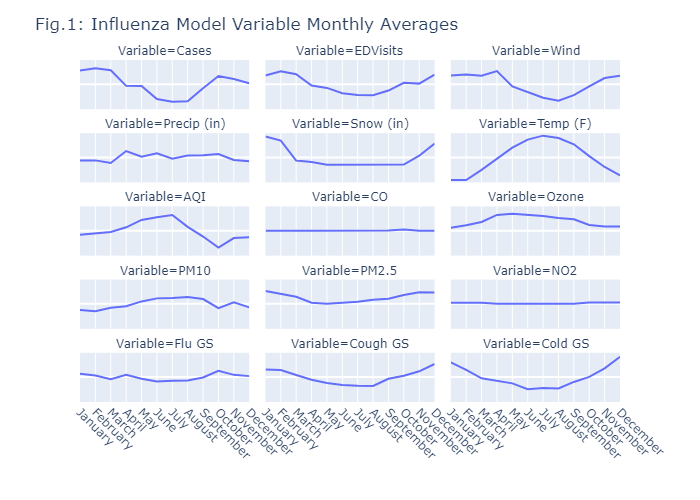

In [22]:
fig = px.line(melted_scaled_monthly, x='Month',y='value',facet_col='Variable',facet_col_wrap=3, facet_col_spacing=0.03)
fig.update_layout(title='Fig.1: Influenza Model Variable Monthly Averages')
fig.update_xaxes(categoryorder='array', categoryarray=months_ordered,title='',tickangle=45)
fig.update_yaxes(title='', tickvals = ['','',''])
fig.show('png')

We will also transform the full scaled dataset to long-format

In [23]:
melted_scaled = scaled_df.reset_index()[cont_vars].melt()

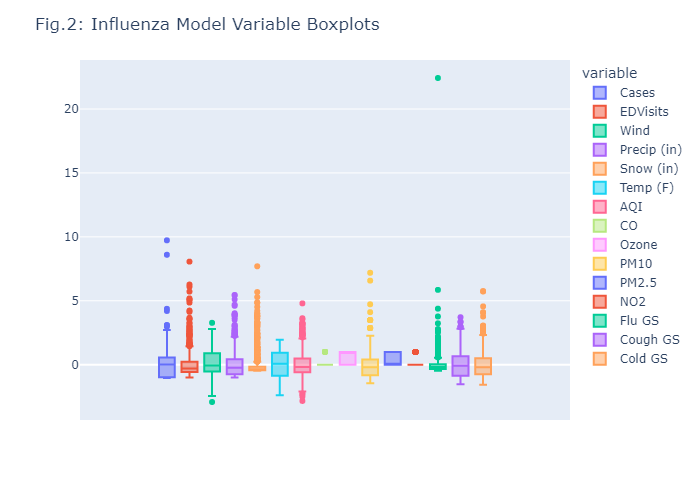

In [24]:
fig = px.box(melted_scaled,y='value', color='variable')
fig.update_layout(title='Fig.2: Influenza Model Variable Boxplots')
fig.update_yaxes(title='',)
fig.show('png')

Cases, EDvisits, wind, snow, and Google search trends follow apparent seasonal trends, with dips during the summer months. Temperature, AQI, and PM10 have apparent seasonal dips during the winter months. 

Cases, ED visits, precipitation, snow, PM10, and Google search trends have right-skewed distributions, with many upper outliers. In particular, Google searches for flu present with an upper outlier that is significantly larger in scale than any of the other variables’ upper outliers.

Let's take a look at collinearity 

In [42]:
corr_matrix = scaled_df[cont_vars].corr()
pvals = scaled_df[cont_vars]\
                    .corr(method=lambda x,y: \
                            pearsonr(x,y,)[1]
                        ) - np.eye(*corr_matrix.shape)
p = pvals.applymap(lambda x: \
                    ''.join(
                        ['*' for t in [.05,.01,.001] if x<=t]
                        )
                    )
corr_matrix_sigs = corr_matrix[cont_vars].round(2).astype(str) + p
corr_matrix_sigs

,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,PM10,PM2.5,NO2,Flu GS,Cough GS,Cold GS
Cases,1.0***,0.58***,0.29***,-0.04,0.22***,-0.57***,-0.29***,0.01,-0.28***,-0.18***,0.24***,0.09*,0.27***,0.17***,0.23***
EDVisits,0.58***,1.0***,0.24***,-0.01,0.17***,-0.43***,-0.26***,-0.04,-0.11**,-0.21***,0.15***,-0.09*,0.33***,0.59***,0.45***
Wind,0.29***,0.24***,1.0***,0.2***,0.3***,-0.5***,-0.28***,0.02,-0.12**,-0.23***,0.08*,0.1**,0.07*,0.23***,0.3***
Precip (in),-0.04,-0.01,0.2***,1.0***,0.03,0.13***,-0.17***,-0.03,0.07,-0.17***,-0.06,-0.02,0.12**,-0.01,-0.03
Snow (in),0.22***,0.17***,0.3***,0.03,1.0***,-0.58***,-0.14***,-0.02,-0.29***,-0.19***,0.28***,0.05,0.03,0.18***,0.41***
Temp (F),-0.57***,-0.43***,-0.5***,0.13***,-0.58***,1.0***,0.35***,-0.01,0.47***,0.28***,-0.43***,-0.14***,-0.12**,-0.37***,-0.56***
AQI,-0.29***,-0.26***,-0.28***,-0.17***,-0.14***,0.35***,1.0***,-0.19***,0.14***,0.43***,-0.06,-0.12**,-0.18***,-0.31***,-0.34***
CO,0.01,-0.04,0.02,-0.03,-0.02,-0.01,-0.19***,1.0***,-0.11**,-0.0,-0.07,-0.02,-0.0,-0.08*,-0.07*
Ozone,-0.28***,-0.11**,-0.12**,0.07,-0.29***,0.47***,0.14***,-0.11**,1.0***,0.02,-0.92***,-0.22***,-0.01,-0.14***,-0.24***
PM10,-0.18***,-0.21***,-0.23***,-0.17***,-0.19***,0.28***,0.43***,-0.0,0.02,1.0***,-0.04,0.07,-0.12***,-0.22***,-0.25***


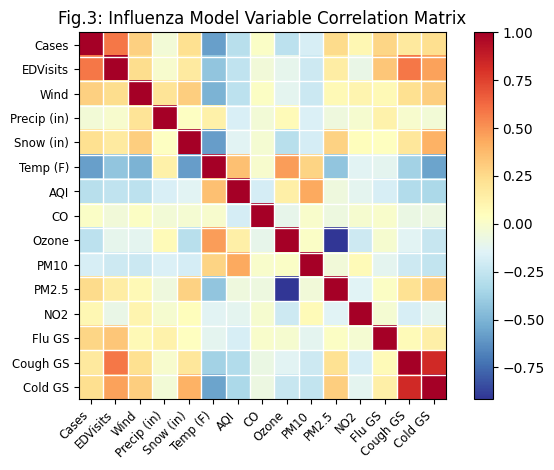

In [43]:
sm.graphics.plot_corr(corr_matrix,
                        xnames=cont_vars, 
                        title='Fig.3: Influenza Model Variable Correlation Matrix'
                        ).show()

In [44]:
vif = pd.DataFrame()
vif['variable'] = scaled_df[cont_vars].columns
vif['VIF'] = [
                variance_inflation_factor(scaled_df[cont_vars].values,i) \
                for i in range(len(cont_vars))
                ]

print(tabulate(vif, headers=vif.columns))

    variable         VIF
--  -----------  -------
 0  Cases        2.29917
 1  EDVisits     2.87311
 2  Wind         1.5433
 3  Precip (in)  1.25201
 4  Snow (in)    1.71599
 5  Temp (F)     3.88875
 6  AQI          1.6181
 7  CO           1.08142
 8  Ozone        1.1533
 9  PM10         1.34005
10  PM2.5        1.20432
11  NO2          1.14465
12  Flu GS       1.26075
13  Cough GS     5.4652
14  Cold GS      5.19432


Multicollinearity is present within the continuous variables. Notably, Google searches for cough and cold have a correlation coefficient of 0.83, and Ozone and PM2.5 have a correlation coefficient of -0.92. Model variables with correlation coefficients approaching |1| are highly collinear and may cause problems in linear modeling. Google search trends for cough and cold have similar and moderately large variance inflation factors. In addition, the variance inflation factor of temperature is mildly high.

---
**Associations between categorical variables month and main pollutant will be explored with Chi2 test of association and visualized with a stacked bar chart.**

To create the contingency table, each category is given a dummy variable binary representation

In [32]:
df_month_pollutant = df[['Month','Main Poll']]

df_month_dummy_pollutant = pd.get_dummies(
                                df_month_pollutant\
                                .set_index('Main Poll')['Month']
                                ).reset_index()
month_pollutant_freq = df_month_dummy_pollutant\
                                .groupby('Main Poll')\
                                .sum()[months_ordered]
print(tabulate(month_pollutant_freq.T, 
                headers=month_pollutant_freq.T.columns)
                )

             CO    NO2    Ozone    PM2.5
---------  ----  -----  -------  -------
January       0      4       11       47
February      1      3       18       34
March         0      4       32       26
April         0      0       57        4
May           0      0       61        0
June          0      0       56        4
July          0      0       56        8
August        0      0       49       16
September     1      0       44       20
October       4      5       22       35
November      0      4       16       44
December      0      5       16       43


We use the Chi-Square test to examine the relationships between Month and Main Pollutant categories

In [33]:
stat, p, dof, expected = chi2_contingency(month_pollutant_freq)

print(f"Chisq         : {stat}")
print(f"p-value       : {p}")
print(f"Deg. Freedom  : {dof}")

Chisq         : 304.13808250339616
p-value       : 1.2884077202528089e-45
Deg. Freedom  : 33


A Chi-Square test of association with p-value < 0.001 suggests that these observed differences in main pollutants by month are not due to chance alone.

In [35]:
month_pollutant_freq

,January,February,March,April,May,June,July,August,September,October,November,December
Main Poll,,,,,,,,,,,,
CO,0,1,0,0,0,0,0,0,1,4,0,0
NO2,4,3,4,0,0,0,0,0,0,5,4,5
Ozone,11,18,32,57,61,56,56,49,44,22,16,16
PM2.5,47,34,26,4,0,4,8,16,20,35,44,43


*Transforming to long format...*

In [39]:
melted_month_pollutant_freq = month_pollutant_freq.reset_index()\
                                .melt(
                                    id_vars='Main Poll',
                                    value_vars=months_ordered, 
                                    var_name='Month',
                                    value_name='freq'
                                    )

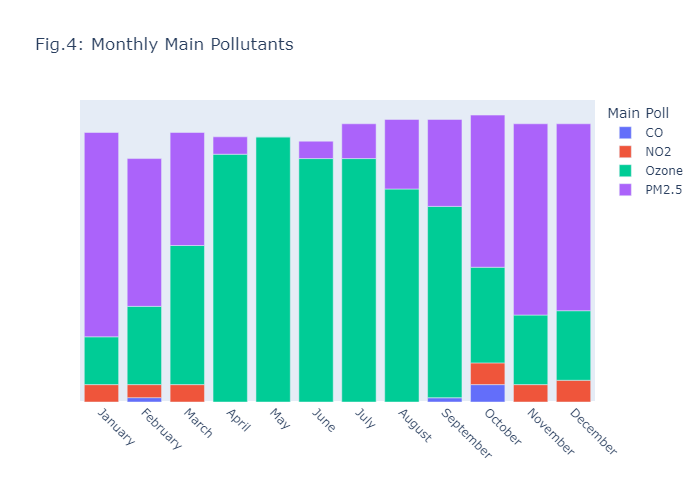

In [41]:
fig = px.bar(melted_month_pollutant_freq, x='Month',y='freq', color='Main Poll', title='Fig.4: Monthly Main Pollutants')
fig.update_xaxes(title='',tickangle=45)
fig.update_yaxes(title='',tickvals=['','','',''])
fig.show('png')

Ozone and PM2.5 follow seasonal patterns, with ozone more likely to be the main pollutant during the summer months, and PM2.5 being more likely to be the main pollutant in the winter.

---
**ILI cases will be modeled with months alone and with months + other variables to explore the impact of the other variables on cases.**

For our first model we will include only the months alongside a constant as predictors of ILI cases. We drop June from the model to act as the comparison month

In [51]:
## Months Model ##

x = sm.add_constant(scaled_df[
                        [f'month_{m}' for m in range(1,13) if m != 6]
                        ])
y = scaled_df['Cases']
mod = sm.OLS(endog=y, exog=x, hasconst=True).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     56.85
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           9.40e-91
Time:                        16:26:37   Log-Likelihood:                -834.05
No. Observations:                 750   AIC:                             1692.
Df Residuals:                     738   BIC:                             1748.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8779      0.096     -9.168      0.000      -1.066      -0.690
month_1        1.7001      0.134     12.658      0.000       1.436       1.964
month_2        1.8326      0.138     13.298      0.000       1.562       2.103
month_3        1.7107      0.134     12.736      0.000       1.447       1.974
month_4        0.7844      0.135      5.817      0.000       0.520       1.049
month_5        0.7736      0.135      5.736      0.000       0.509       1.038
month_7       -0.1576      0.133     -1.182      0.237      -0.419       0.104
month_8       -0.1313      0.133     -0.989      0.323      -0.392       0.129
month_9        0.6406      0.133      4.824      0.000       0.380       0.901
month_10       1.3668      0.132     10.331      0.000       1.107       1.627
month_11       1.1871      0.133      8.907      0.000       0.925       1.449
month_12       0.9384      0.133      7.041      0.000       0.677       1.200
==============================================================================
Omnibus:                      835.680   Durbin-Watson:                   0.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95336.797
Skew:                           5.124   Prob(JB):                         0.00
Kurtosis:                      57.275   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Next we add the remaining variables to the model

In [46]:
## Months and Variables Model ##

x = sm.add_constant(scaled_df.drop(columns=['Cases','month_6']))
y = scaled_df['Cases']
mod = sm.OLS(endog=y, exog=x, hasconst=True).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     53.32
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          2.39e-142
Time:                        16:24:22   Log-Likelihood:                -682.82
No. Observations:                 750   AIC:                             1416.
Df Residuals:                     725   BIC:                             1531.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5140      0.108     -4.738      0.000      -0.727      -0.301
EDVisits        0.5383      0.034     15.960      0.000       0.472       0.605
Wind           -0.0339      0.030     -1.138      0.255      -0.092       0.025
Precip (in)     0.0203      0.025      0.802      0.423      -0.029       0.070
Snow (in)      -0.0394      0.031     -1.263      0.207      -0.101       0.022
Temp (F)       -0.1283      0.073     -1.756      0.080      -0.272       0.015
AQI            -0.0649      0.033     -1.972      0.049      -0.130      -0.000
CO             -0.4049      0.211     -1.917      0.056      -0.819       0.010
Ozone          -0.0660      0.070     -0.941      0.347      -0.204       0.072
PM10            0.0317      0.026      1.198      0.231      -0.020       0.084
PM2.5          -0.0025      0.074     -0.033      0.973      -0.147       0.143
NO2            -0.0406      0.119     -0.340      0.734      -0.275       0.194
Flu GS          0.0300      0.025      1.188      0.235      -0.020       0.080
Cough GS       -0.3823      0.052     -7.389      0.000      -0.484      -0.281
Cold GS         0.0704      0.054      1.309      0.191      -0.035       0.176
month_1         1.0728      0.200      5.366      0.000       0.680       1.465
month_2         1.1016      0.203      5.434      0.000       0.704       1.500
month_3         1.0467      0.173      6.044      0.000       0.707       1.387
month_4         0.4883      0.141      3.472      0.001       0.212       0.764
month_5         0.5762      0.117      4.910      0.000       0.346       0.807
month_7        -0.0929      0.112     -0.828      0.408      -0.313       0.127
month_8        -0.1467      0.114     -1.285      0.199      -0.371       0.077
month_9         0.5374      0.118      4.559      0.000       0.306       0.769
month_10        0.9529      0.141      6.774      0.000       0.677       1.229
month_11        0.8282      0.163      5.084      0.000       0.508       1.148
month_12        0.3932      0.188      2.094      0.037       0.025       0.762
==============================================================================
Omnibus:                      267.563   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5810.097
Skew:                           1.066   Prob(JB):                         0.00
Kurtosis:                      16.468   Cond. No.                     3.97e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.73e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The linear regression model based on months alone explains 46% of the variance in Kent County ILI cases. The model based on months and the other variables explains 64% of the variance in cases. Moreover, the AIC/BIC scores decrease with the added variables of interest, indicating a better fit.

---
**The stationarity of ILI cases will be tested using ACF plots and the Adfuller Test of Stationarity. If the series fails to show stationarity, another Adfuller test will be performed on the first-differenced data.**

A series may be considered stationary if it maintains a constant mean, variance, and covariance over time. In a disease time series, localized shocks may impact stationarity, such as how increasing community influenza transmission during epidemics lead to higher incidence trends in the following months. As such, it's sometimes necessary to perform a first-distancing transformation on the series to examine the change in incidence from month-to-month (i.e., Yt – Yt-1). 

In [52]:
cases_series = scaled_df[['Cases']]

ADF Statistic: -2.29
p-value: 0.17
lags: 51
Critial Values:
   1%, -3.44
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57


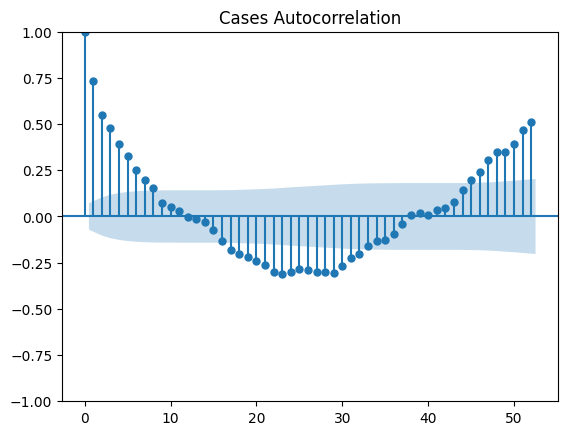

In [55]:
ADF(cases_series, max_lags=52)

plot_acf(cases_series, 
            lags = 52, 
            title='Cases Autocorrelation'
            ).show()

The Ad-Fuller Test is used to test the hypothesis that a series is nonstationary. The cases series fails this test, and its ACF plot demonstrates a cyclic trend in correlations between specific time points and lagged values 1-52 weeks prior.

So, let's perform a first-differencing transformaton and try again.

In [58]:
first_diff_cases_series\
    = difference(cases_series['Cases'],1)

ADF Statistic: -11.78
p-value: 0.00
lags: 50
Critial Values:
   1%, -3.44
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57


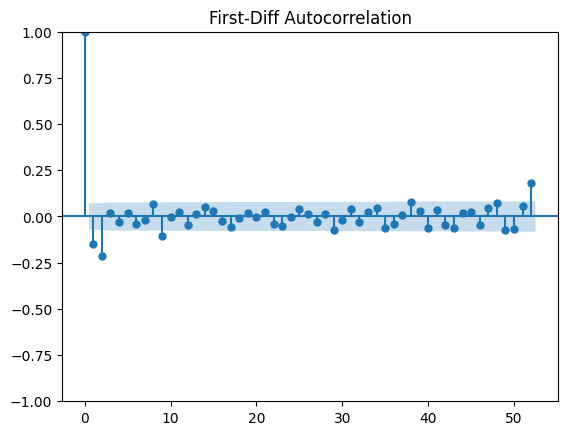

In [62]:
ADF(first_diff_cases_series,52)

plot_acf(first_diff_cases_series, 
            lags = 52, 
            title='First-Diff Autocorrelation'
        ).show()

After a first-differencing transformation, the series rejects the Ad-Fuller null hypothesis and may be assumed to be stationary. Indeed, there is no apparent trend in the ACF plot of the first-differenced series – significant correlations are only seen at lags of 1, 2, and 52 weeks

The transformation was enough to remove the series trend to produce a stationary series.

---
**If the cases series or its first-differenced transformation are indeed stationary, an autoregression model will be developed to explore any lagged-effects of past weeks in the data.**

First we tell the program that our data is indeed weekly data

In [63]:
cases_series.index = pd.to_datetime(cases_series.index)
cases_series = cases_series.resample('W').first()
cases_series['Cases'] = cases_series['Cases'].fillna(method='ffill')

In [64]:
cases_series_preds = cases_series.copy()

In [65]:
mod = AutoReg(cases_series, 52)
res = mod.fit()
print(res.summary())

cases_series_preds['Nonseasonal'] = res.predict()

                            AutoReg Model Results                             
Dep. Variable:                  Cases   No. Observations:                  752
Model:                    AutoReg(52)   Log Likelihood                -653.568
Method:               Conditional MLE   S.D. of innovations              0.616
Date:                Thu, 14 Dec 2023   AIC                           1415.135
Time:                        17:03:48   BIC                           1660.894
Sample:                    07-30-2006   HQIC                          1510.136
                         - 12-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.023      0.235      0.814      -0.040       0.051
Cases.L1       0.6468      0.037     17.334      0.000       0.574       0.720
Cases.L2      -0.1449      0.045     -3.247      0.0

In [66]:
mod = AutoReg(cases_series, seasonal=True, lags=52)
res = mod.fit()
print(res.summary())

cases_series_preds['Seasonal'] = res.predict()

                            AutoReg Model Results                             
Dep. Variable:                  Cases   No. Observations:                  752
Model:              Seas. AutoReg(52)   Log Likelihood                -592.012
Method:               Conditional MLE   S.D. of innovations              0.564
Date:                Thu, 14 Dec 2023   AIC                           1394.025
Time:                        17:05:44   BIC                           1871.888
Sample:                    07-30-2006   HQIC                          1578.747
                         - 12-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4760      0.191     -2.494      0.013      -0.850      -0.102
s(2,52)       -0.0690      0.225     -0.306      0.759      -0.511       0.373
s(3,52)       -0.0586      0.239     -0.245      0.8

Transforming to long-format for easier visualization...

In [67]:
series_preds_melted = cases_series_preds[['Cases','Nonseasonal','Seasonal']]\
                        .reset_index().melt(id_vars='weekstart',var_name='Series')\
                        .set_index('weekstart')

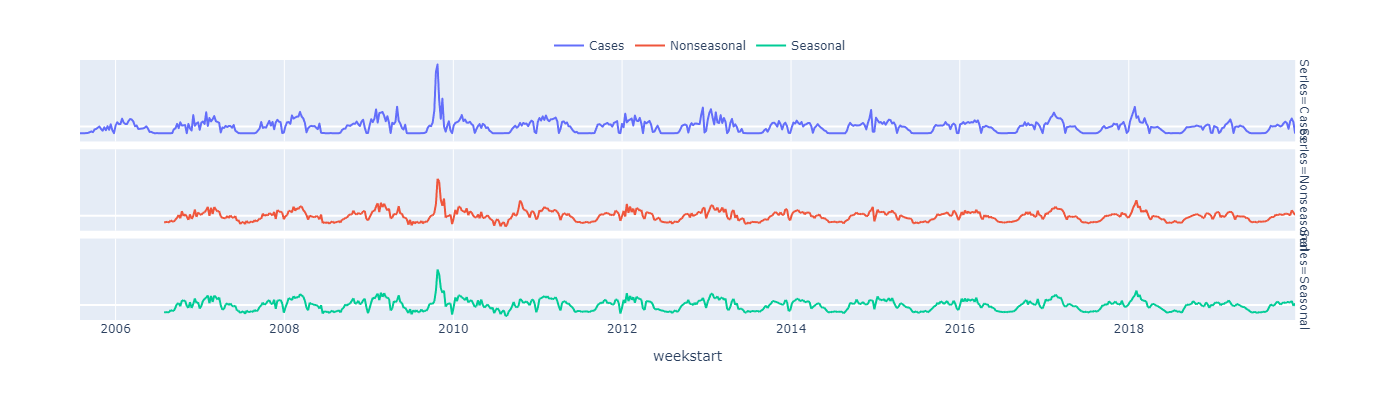

In [68]:
fig=px.line(series_preds_melted,facet_row='Series',color='Series')
fig.update_layout(
                    autosize=False,
                    width=1400,
                    height=400, 
                    title='', 
                    legend=dict(
                                title=None, 
                                orientation="h", 
                                y=1, 
                                yanchor="bottom", 
                                x=0.5, 
                                xanchor="center"
                                )
                    )

fig.update_yaxes(title='', tickvals=['','',''])

fig.show('png')

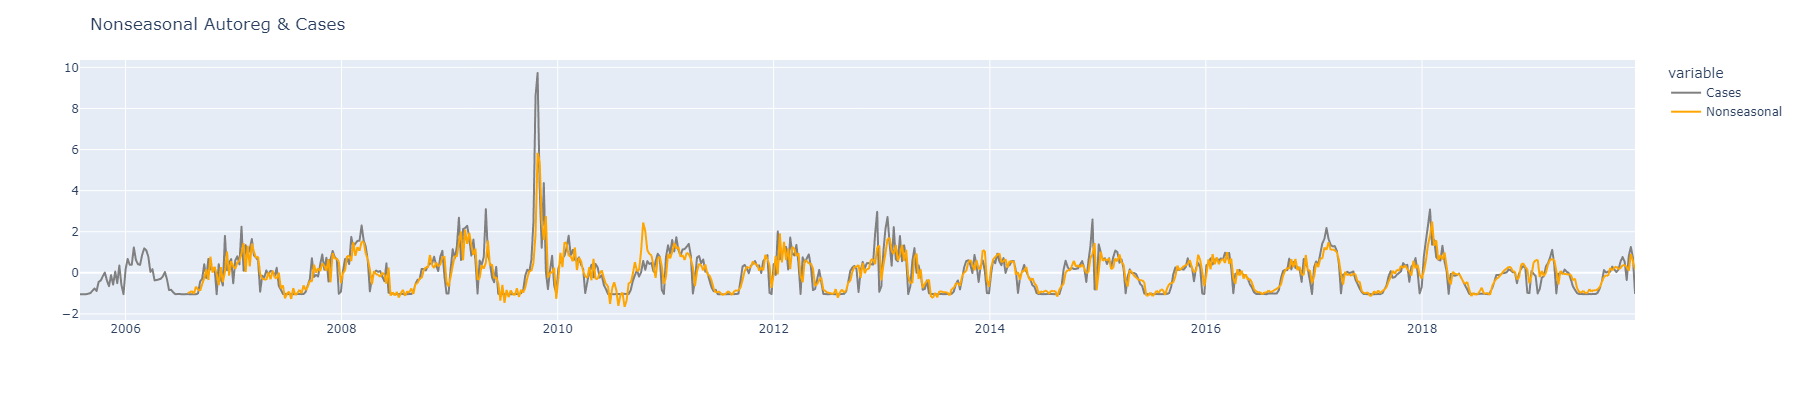

In [71]:
fig = px.line(
    cases_series_preds[['Cases','Nonseasonal']], 
    color_discrete_map={'Nonseasonal':'orange','Cases':'grey'}
    )
fig.update_layout(
                autosize=False,
                width=1800,
                height=400, 
                title='Nonseasonal Autoreg & Cases'
                )
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig.show('png')

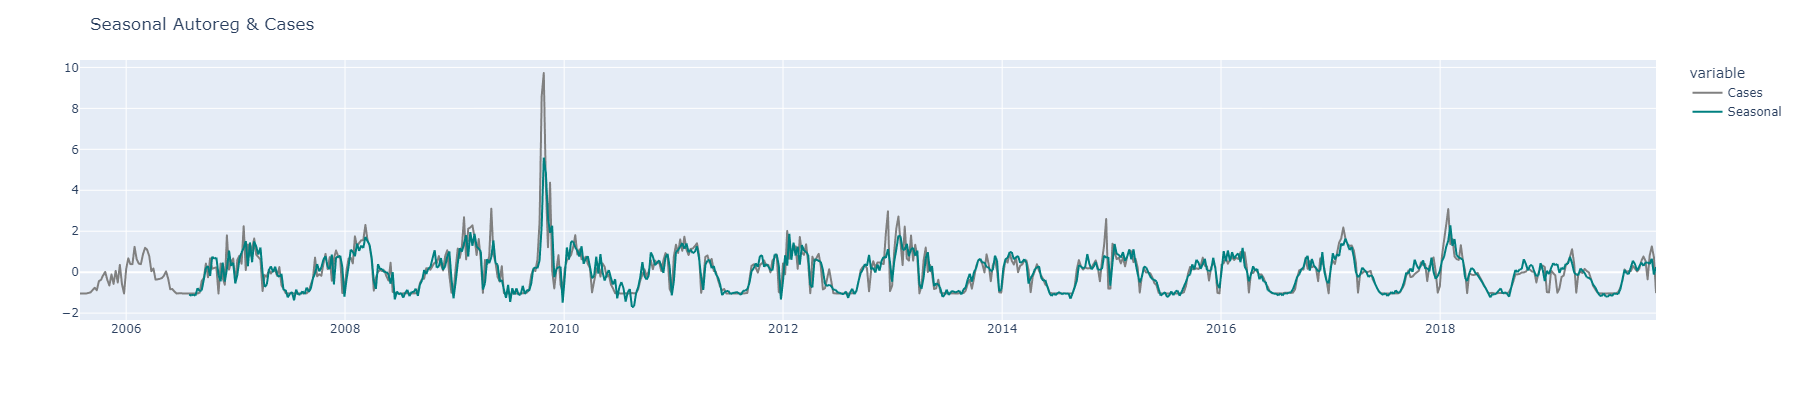

In [70]:
fig = px.line(
    cases_series_preds[['Cases','Seasonal']], 
    color_discrete_map={'Cases':'grey','Seasonal':'teal'}
    )
fig.update_layout(
                autosize=False,
                width=1800,
                height=400, 
                title='Seasonal Autoreg & Cases'
                )
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig.show('png')

---

In this study, time series analysis methods were used to explore disease forecasting applications in local public health. This case study leveraged diverse, heterogeneous online data sources alongside traditional surveillance data to model Influenza-Like Illness (ILI) in Kent County, Michigan between 2006-2019.

*Descriptives & Linear Modeling*

There are notable issues in the descriptive analysis portion of this research, particularly in Figure 2. Many variables have upper outliers indicating non-normal distributions. Google search trends for the term flu had the most significant upper outlier, which may be related to increased online search behaviors during the H1N1 Swine Flu epidemic. Moreover, the data had high collinearity among certain variables. Figure 3 shows a heatmap of correlations among variables, with a significantly high correlations between Google search trends for cough and for cold and a high negative correlation between Ozoneand PM2.5. Figure 4 and Table 2 suggest a strong association between the two categorical variables: Main Pollutant and Month. No transformations were applied to normalize these variables and address these assumption failures before moving on to linear modeling.

The data suggest that simple linear modeling is not the best approach to take with this analysis. In spite of these problems, the attempt at linear modeling was a moderate success, with 64% of ILI variance being explained by our predictor variables. The month terms and the ED visits variable had the strongest overall impact on ILI cases.

*Autoregression*

ACF plots in Figures 5-6 show the correlations between each measurement time point and the measurements 1-52 weeks prior. The first-differenced transformation of ILI cases is particularly notable, with a positive correlation at lagged week 52. This makes sense; the change in ILI incidence between the first and second week in August of this year may be best predicted by the change between those weeks last year. In addition, negative correlations at lagged weeks 1 and 2 may represent gradual declines in ILI incidence after significant outbreaks. These figures together with the Ad-Fuller test results in Table 6 suggest that ILI cases are a strong candidate for autoregression. Likewise, the autoregression model prediction plots in Figure 7 further support the use of autoregression in Kent County ILI modeling.

*Conclusion* 

There are issues with the representativeness and generalizability of these results in Kent County. ED visits, as well as reported ILI cases, underrepresent individuals with low-access to healthcare. Furthermore, Google search trends do not effectively capture information-seeking behaviors in individuals with limited access to the internet, due to finances, lack of knowledge, and other systemic factors. Importantly, underrepresented communities are more likely to overlap with minoritized populations who already experience poor health outcomes. Black communities feel justified distrust of the healthcare system due to historical harm done to the community, for instance. Another example is young queer people who are more likely to be homeless with limited access to Google. 

The incomplete model of ILI created here should not be used for forecasting in Kent County, due in part to its underrepresentation of marginalized communities. Rather, these findings suggest that infectious disease modeling has promising applications in local public health. Moving forward, next steps involve the addition of ED visits, weather/pollution measurements, and Google search trends as exogenous variables in a more cohesive autoregressive model of ILI, using a Box-Jenkins approach.
